### Observation: 
captum model gives incorrect predictions

Why does feature vis only work on captum model? ReLU removed for feature visualisation model? Why can’t I predict with this model? Why is there another neuron spiking more? 

## Set up

In [2]:
import os
base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) 

In [52]:
# import requests # request img from web
# import shutil # save img locally
# from pathlib import Path
from PIL import Image
# import numpy as np
# import math
# import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

In [4]:
import sys
sys.path.append(f'{base_dir}/src/captum')
from captum import optim as optimviz

The tqdm package is required to use captum.optim's n_steps stop criteria with progress bar


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Might need: 
https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system 
https://discuss.pytorch.org/t/torch-cuda-is-available-returns-false-but-cudnn-is-present/67698 

## Running models on one image - checking model output

In [7]:
filename = f'{base_dir}/data/test-images/mixed4e55_imagenet/mixed4e55_imagenet_im_0.png'

In [8]:
input_image = Image.open(filename).convert('RGB') # since 'RGBA'
preprocess = transforms.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [11]:
googlenet_torchhub = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
googlenet_torchhub.eval() 

Using cache found in /home/lauraom/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
googlenet_torchvision = torchvision.models.googlenet(pretrained=True).to(device)
googlenet_torchvision.eval()

/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [18]:
googlenet_captum = optimviz.models._image.inception_v1.googlenet(pretrained=True).to(device)
googlenet_captum.eval()

InceptionV1(
  (conv1): Conv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv1_relu): RedirectedReluLayer()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (local_response_norm1): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_relu): RedirectedReluLayer()
  (conv3): Conv2dSame(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (conv3_relu): RedirectedReluLayer()
  (local_response_norm2): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (mixed3a): InceptionModule(
    (conv_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce_relu): RedirectedReluLayer()
    (conv_3x3): Conv2dSame(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv_5x5_reduce): Conv2d(192, 16, kernel_size=(1, 1), str

In [12]:
model = googlenet_torchhub
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([1.4836e-04, 1.1629e-04, 2.3431e-04, 4.7253e-04, 2.9637e-04, 3.2284e-04,
        7.0787e-05, 3.8124e-05, 5.8596e-05, 9.7313e-05, 1.3800e-04, 6.6388e-05,
        6.5317e-05, 6.2140e-05, 3.4331e-05, 1.4559e-04, 2.9627e-04, 4.6417e-05,
        7.9945e-05, 6.3190e-04, 2.8289e-04, 2.9461e-03, 6.0559e-04, 8.1032e-05,
        2.8202e-03, 2.4523e-04, 8.0806e-04, 3.6671e-04, 3.4419e-04, 1.9776e-04,
        1.2714e-04, 6.0358e-05, 1.6476e-04, 8.7376e-05, 9.2066e-05, 2.7396e-04,
        4.5946e-04, 8.4472e-05, 6.4846e-04, 1.6550e-04, 4.3778e-05, 1.8952e-04,
        1.1160e-04, 8.7961e-04, 1.0928e-04, 1.5842e-04, 4.4956e-05, 1.2878e-04,
        1.6853e-04, 1.3153e-04, 6.8381e-05, 7.6278e-04, 1.6640e-04, 2.6980e-04,
        2.3369e-04, 2.9899e-05, 1.0687e-04, 1.2032e-04, 5.0644e-05, 1.6376e-04,
        1.1057e-04, 1.0312e-04, 1.4460e-04, 7.0214e-04, 7.4663e-04, 2.8606e-04,
        3.2331e-04, 7.2173e-05, 2.2726e-04, 1.3189e-04, 7.1253e-05, 1.7211e-04,
        3.0035e-04, 1.2961e-03, 3.7797e-

In [26]:
alexnet = torchvision.models.alexnet(pretrained=True).to(device)

/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Read the categories
with open(f"{base_dir}/data/Files/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Egyptian cat 0.2509225606918335
tabby 0.19748789072036743
lynx 0.05643321946263313
Persian cat 0.05410971865057945
tiger cat 0.04717537760734558


In [15]:
len(probabilities) # 1000
probabilities.shape # torch.Size([1000])

torch.Size([1000])

In [19]:
model = googlenet_torchvision
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([1.4836e-04, 1.1629e-04, 2.3431e-04, 4.7253e-04, 2.9637e-04, 3.2284e-04,
        7.0787e-05, 3.8124e-05, 5.8596e-05, 9.7313e-05, 1.3800e-04, 6.6388e-05,
        6.5317e-05, 6.2140e-05, 3.4331e-05, 1.4559e-04, 2.9627e-04, 4.6417e-05,
        7.9945e-05, 6.3190e-04, 2.8289e-04, 2.9461e-03, 6.0559e-04, 8.1032e-05,
        2.8202e-03, 2.4523e-04, 8.0806e-04, 3.6671e-04, 3.4419e-04, 1.9776e-04,
        1.2714e-04, 6.0358e-05, 1.6476e-04, 8.7376e-05, 9.2066e-05, 2.7396e-04,
        4.5946e-04, 8.4472e-05, 6.4846e-04, 1.6550e-04, 4.3778e-05, 1.8952e-04,
        1.1160e-04, 8.7961e-04, 1.0928e-04, 1.5842e-04, 4.4956e-05, 1.2878e-04,
        1.6853e-04, 1.3153e-04, 6.8381e-05, 7.6278e-04, 1.6640e-04, 2.6980e-04,
        2.3369e-04, 2.9899e-05, 1.0687e-04, 1.2032e-04, 5.0644e-05, 1.6376e-04,
        1.1057e-04, 1.0312e-04, 1.4460e-04, 7.0214e-04, 7.4663e-04, 2.8606e-04,
        3.2331e-04, 7.2173e-05, 2.2726e-04, 1.3189e-04, 7.1253e-05, 1.7211e-04,
        3.0035e-04, 1.2961e-03, 3.7797e-

In [21]:
# Read the categories
with open(f"{base_dir}/data/Files/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Egyptian cat 0.2509225606918335
tabby 0.19748789072036743
lynx 0.05643321946263313
Persian cat 0.05410971865057945
tiger cat 0.04717537760734558


In [22]:
len(probabilities) # 1000
probabilities.shape # torch.Size([1000])

torch.Size([1000])

In [23]:
model = googlenet_captum
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

/mnt/c/Users/lauraa.omahony/Documents/~PhD_Stuff/1_Workspace/sw-interpretability/src/captum/captum/optim/models/_image/inception_v1.py:209: UserWarning: Model input has values outside of the range [0, 1].
  warn("Model input has values outside of the range [0, 1].")


tensor([2.4838e-09, 1.1637e-03, 1.8743e-08,  ..., 2.4836e-09, 2.4838e-09,
        2.4837e-09])


In [24]:
# Read the categories
with open(f"{base_dir}/data/Files/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

green snake 0.3640095293521881
hen 0.2313622087240219
Norwegian elkhound 0.14480169117450714
brambling 0.14257130026817322
silky terrier 0.04878323897719383


In [25]:
len(probabilities) # 1008
# probabilities.shape # torch.Size([1008])

1008

In [ ]:
# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

## Feature visualisation

class NeuronActivation:

https://github.com/pytorch/captum/blob/optim-wip/captum/optim/_core/loss.py line 251

class ChannelActivation:

https://github.com/pytorch/captum/blob/optim-wip/captum/optim/_core/loss.py line 218

class InputOptimization:

https://github.com/pytorch/captum/blob/optim-wip/captum/optim/_core/optimization.py line 30

class n_steps:

https://github.com/pytorch/captum/blob/optim-wip/captum/optim/_core/optimization.py line 163

In [29]:
neuron = 5
target_captum = googlenet_captum.conv2
target_torchvision = googlenet_torchvision.conv2

There are 128 steps in the history.
Initial loss is -10.247906684875488.
Final loss is -69.42400360107422.


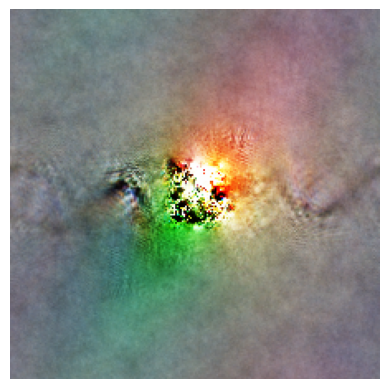

In [32]:
# Try for neuron activation objective
# Create a loss function
loss_fn = optimviz.loss.NeuronActivation(target_captum, neuron)
# Run the optimization
obj = optimviz.InputOptimization(googlenet_captum, loss_fn)
history = obj.optimize(optimviz._core.optimization.n_steps(128,show_progress=False))
print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")
# View the opticlass NeuronActivation:
obj.input_param().show()

There are 128 steps in the history.
Initial loss is -19.84897804260254.
Final loss is -107.29216003417969.


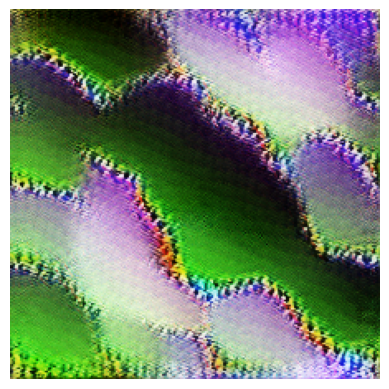

In [33]:
# Same but channel 
loss_fn = optimviz.loss.ChannelActivation(target_captum, neuron)
obj = optimviz.InputOptimization(googlenet_captum, loss_fn)
history = obj.optimize(optimviz._core.optimization.n_steps(128,show_progress=False))
print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")
obj.input_param().show()

In [ ]:
# Initialize a series of transformations
transforms = torch.nn.Sequential(
    # Normalization for torchvision models ###### Alexnet...? 
    ### torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Random translation, scaling, and rotation to help with visualization quality.
    # Padding is used to avoid transform artifacts and then it's cropped away.
    torch.nn.ReflectionPad2d(16),
    optimviz.transforms.RandomSpatialJitter(16),
    optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5,5)),
    optimviz.transforms.RandomSpatialJitter(8),
    optimviz.transforms.CenterCrop((224,224)),
)

In [35]:
# Initialize an input - NaturalImage uses FFT parameterization and color decorrelation
image = optimviz.images.NaturalImage((224, 224)).to(device) # This creates a Module that returns an ImageTensor
# Choose a target layer to optimize
# target = ...
# Create a loss function based on the target layer
loss_fn = optimviz.loss.NeuronActivation(target_captum, neuron)
# Initialize InputOptimization
obj = optimviz.InputOptimization(googlenet_captum, loss_fn, image, transforms)
history = obj.optimize(optimviz._core.optimization.n_steps(128, show_progress=False)) 
print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")
image().show()

TypeError: 'module' object is not callable

In [39]:
target_captum = googlenet_captum.mixed3a 
target_torchvision = googlenet_torchvision.inception3a 

In [40]:
# 
image = optimviz.images.NaturalImage((224, 224)).to(device) 
loss_fn = optimviz.loss.NeuronActivation(target_captum, neuron)
obj = optimviz.InputOptimization(googlenet_captum, loss_fn, image, transforms)
history = obj.optimize(optimviz._core.optimization.n_steps(128, show_progress=False)) 
print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")
image().show()

TypeError: 'module' object is not callable

In [57]:
# 
image = optimviz.images.NaturalImage((224, 224)).to(device) 
loss_fn = optimviz.loss.ChannelActivation(target_captum, neuron)
obj = optimviz.InputOptimization(googlenet_captum, loss_fn, image, transforms)
history = obj.optimize(optimviz._core.optimization.n_steps(128, show_progress=False)) 
print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")
image().show()

TypeError: 'module' object is not callable

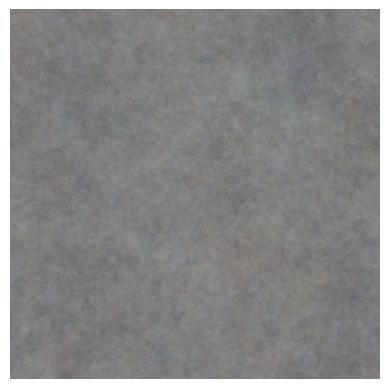

In [58]:
# Another way to retrieve the image is via `input_param()`
obj.input_param().show()

### Feature visualisation function

For convenience, we can create a helper function for visualizing different layers in our model.

In [38]:
def visualize(model: torch.nn.Module, target: torch.nn.Module, neuron: int = -1, 
              neuron_obj: bool = True, lr: float = 0.025) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = [
        # Normalization for torchvision models
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # Random translation, scaling, and rotation to help with visualization quality.
        # Padding is used to avoid transform artifacts and then it's cropped away.
        torch.nn.ReflectionPad2d(16),
        optimviz.transforms.RandomSpatialJitter(16),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.CenterCrop((224,224)),
    ]
    transforms = torch.nn.Sequential(*transforms)
    if isinstance(model, optimviz.models.InceptionV1):
        # For the GoogLeNet model, we don't need the initial normalization
        transforms = transforms[1:]
        print("transforms[1:]") ################## test
    else: ######################################## test
        print("transforms") ###################### test
    if neuron > -1:
        if neuron_obj is True: 
            loss_fn = optimviz.loss.NeuronActivation(target, neuron)
        else:
            loss_fn = optimviz.loss.ChannelActivation(target, neuron)
    else:
        loss_fn = optimviz.loss.DeepDream(target)
    obj = optimviz.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(optimviz.optimization.n_steps(128, show_progress=False), lr=lr)   

    print(f"""There are {len(history)} steps in the history.
    Initial loss is {history[0].item()}.
    Final loss is {history[-1].item()}.""")

    image().show()

#### GoogleNet

In [ ]:
neuron = 5
target_captum = googlenet_captum.conv2
target_torchvision = googlenet_torchvision.conv2

transforms[1:]
There are 128 steps in the history.
    Initial loss is -29.60305404663086.
    Final loss is -207.12188720703125.


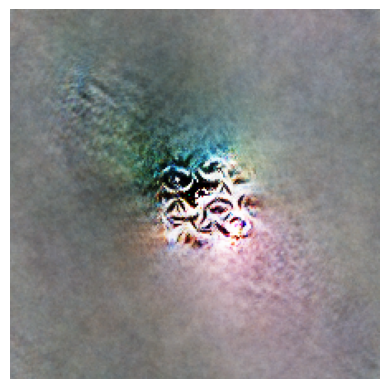

In [44]:
visualize(googlenet_captum, target_captum, neuron)

transforms
There are 128 steps in the history.
    Initial loss is -0.0.
    Final loss is -12.549155235290527.


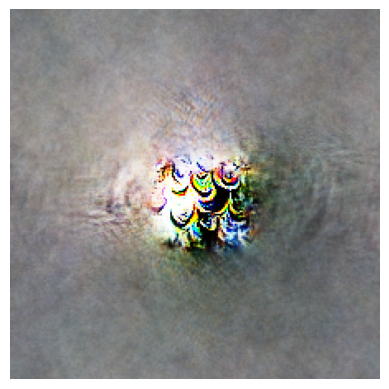

In [43]:
visualize(googlenet_torchvision, target_torchvision, neuron)

In [45]:
neuron = 5
target_captum = googlenet_captum.mixed3a 
target_torchvision = googlenet_torchvision.inception3a 

transforms[1:]
There are 128 steps in the history.
    Initial loss is -41.600494384765625.
    Final loss is -239.6566162109375.


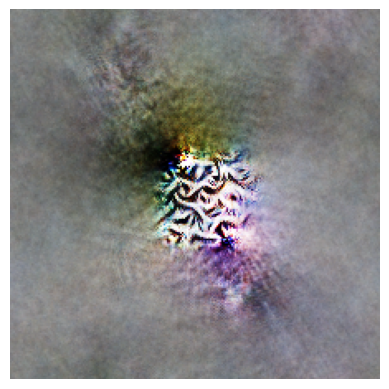

In [46]:
visualize(googlenet_captum, target_captum, neuron)

transforms
There are 128 steps in the history.
    Initial loss is -0.0.
    Final loss is -6.570524215698242.


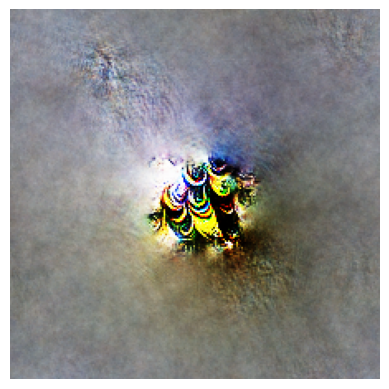

In [47]:
visualize(googlenet_torchvision, target_torchvision, neuron)

In some cases, the neuron of interest may not be activated at all by the initial random input. If this is a ReLU neuron, the zero derivative stops gradient flow backwards and we never move towards any meaningful visualization.

Regular ReLU replaced with with RedirectedReLuLayer

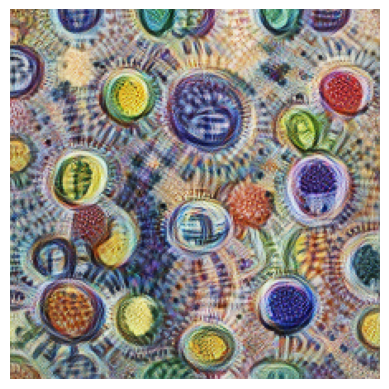

In [48]:
obj = optimviz.InputOptimization(model,
    sum([optimviz.loss.ChannelActivation(model.mixed4a, 476),
        optimviz.loss.ChannelActivation(model.mixed4a, 465),]),
)
obj.optimize(optimviz.optimization.n_steps(128, show_progress=False))
obj.input_param().show() 

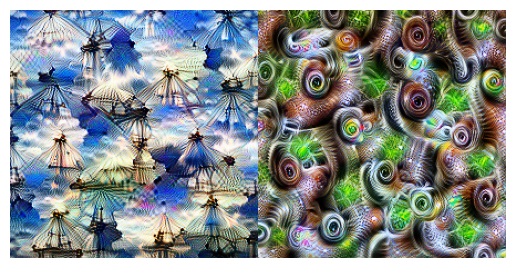

In [49]:
image = optimviz.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([ 
    optimviz.loss.ChannelActivation(model.mixed4a, 492, batch_index=0),
    -optimviz.loss.ChannelActivation(model.mixed4a, 492, batch_index=1),
])
obj = optimviz.InputOptimization(model, loss_fn, image)
history = obj.optimize(optimviz.optimization.n_steps(512, show_progress=False))
image().show()

In [ ]:
image = optimviz.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([ 
    optimviz.loss.ChannelActivation(model.mixed4a, 104, batch_index=0),
    -optimviz.loss.ChannelActivation(model.mixed4a, 104, batch_index=1),
])
obj = optimviz.InputOptimization(model, loss_fn, image)
history = obj.optimize(optimviz.optimization.n_steps(512, show_progress=False))
image().show()

In [ ]:
image = optimviz.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([ 
    optimviz.loss.ChannelActivation(model.mixed4b, 154, batch_index=0),
    -optimviz.loss.ChannelActivation(model.mixed4b, 154, batch_index=1),
])
obj = optimviz.InputOptimization(model, loss_fn, image)
history = obj.optimize(optimviz.optimization.n_steps(512, show_progress=False))
image().show()

In [ ]:
visualize(googlenet_captum, googlenet_captum.mixed4e, 55, False)

#### Finetuned model

In [50]:
path = f"{base_dir}/rough-work/Models/"
dataset_name = 'imagewoof2'
num_class_names = 10

In [53]:
model_iw = torchvision.models.vgg16(pretrained=False)
num_ftrs = model_iw.classifier[6].in_features
model_iw.classifier[6] = nn.Linear(num_ftrs, num_class_names)

/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [54]:
model_iw.load_state_dict(torch.load(f'{path}{dataset_name}/ft_0.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

transforms
There are 128 steps in the history.
    Initial loss is -0.0.
    Final loss is -23.403907775878906.


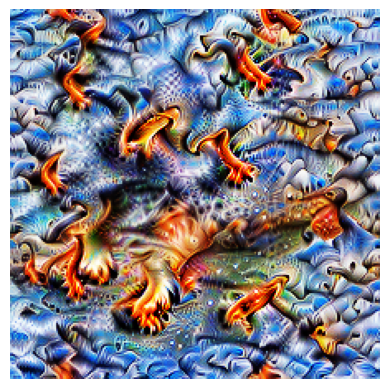

In [55]:
visualize(model_iw, model_iw.features[26], 50, False)